# Convolutions Aren't Convoluted!

Convolution is a basic mathematical operation -- in a very real way, it's only slightly less fundamental than addition and multiplication\*! Because of its fundamental nature, convolution arises repeatedly in both theoretical and applied contexts.

This notebook focuses on the mathematical foundations of convolution. If you're interested in the applications of convolution, check out the [other notebook in this folder](Why%20Are%20Convolutions%20Useful%3F.ipynb).

Below, I assume pretty minimal math background. There is a very elegant view of convolutions that comes from the theory of Fourier transforms and linear algebra. If you're interested, check out [this nice exposition of that point of view](http://www.neurotheory.columbia.edu/Ken/math-notes/math-notes-4.pdf), from Kenneth Miller of Columbia, which does a good job developing the approach gently. There are even loads of neuroscience examples!

\* For the mathematically inclined: convolutions are defined whenever you have a set with a binary operation -- that means groups, monoids, and even categories! Check out [this blog post by Chris Olah](http://colah.github.io/posts/2014-12-Groups-Convolution/) for more on that front, or for a very nice introduction to groups.

## Preliminaries

In [2]:
from __future__ import division

import matplotlib
matplotlib.use("TkAgg")
%pylab inline
plt.xkcd();

from scipy.stats import multivariate_normal

from scipy.io import wavfile
from IPython.display import Audio

import matplotlib.animation as animation
import base64

import scipy.signal
#from PIL import Image

import plotFunks as pF

Populating the interactive namespace from numpy and matplotlib


/Users/charlesfrye/anaconda/envs/jupy/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
`%matplotlib` prevents importing * from pylab and numpy


### Plotting Functions

In [5]:
def plotSignal(signal,signalName):
    plt.figure(figsize=(16,2));
    plt.plot(signal,'-o',color='k');
    pF.cleanPlot(plt.gca()); 
    plt.xlim(-len(signal)/10,len(signal)+len(signal)/10);
    pF.addAxis(plt.gca(),'horizontal');
    plt.title(signalName);

def plotSignalAsDelta(signal,signalName,color='r'):
    plt.figure(figsize=(16,4)); plt.subplot(2,1,1)
    plt.plot(signal,'-o',color='k');
    pF.cleanPlot(plt.gca()); 
    plt.xlim(-len(signal)/10,len(signal)+len(signal)/10);
    pF.addAxis(plt.gca(),'horizontal');
    plt.title(signalName);
    plt.subplot(2,1,2)
    deltaPlot(signal,color=color);
    pF.cleanPlot(plt.gca()); 
    plt.xlim(-len(signal)/10,len(signal)+len(signal)/10);
    pF.addAxis(plt.gca(),'horizontal');
    plt.title('also ' +signalName);
        
def deltaPlot(inp,color='r'):
    plt.scatter(np.arange(0,len(inp)),inp,
                linewidth=0,marker='o',s=36,color=color,
                zorder=10); 
    plt.vlines(np.arange(0,len(inp)),0,inp,)

def plotKronecker():
    pad=[0,0]; padLen = len(pad)
    deltaPlot(pad+[1]+pad,color='b')
    pF.cleanPlot(plt.gca());
    plt.xlim(-padLen/10,2*padLen+1+padLen/10)
    pF.addAxis(plt.gca(),'horizontal');
    plt.title('the delta function')
    
def kernelsPlot(kernels,kernelNames):
    numKernels = len(kernels)
    plt.figure(figsize=(16,4));
    
    for idx,(kernel,name) in enumerate(zip(kernels,kernelNames)):
        plt.subplot(1,numKernels,idx+1)
        deltaPlot(kernel)
        pF.cleanPlot(plt.gca()); 
        plt.xlim(-len(kernel)/10,len(kernel)+len(kernel)/10);
        pF.addAxis(plt.gca(),'horizontal');
        plt.title(name);
        
def convolutionPlot(signals,signalName,kernels,kernelNames):
    for idx,(signal,kernel,kernelName) in enumerate(zip(signals[1:],kernels,kernelNames)):
        plt.figure(figsize=(16,4));
        
        plt.subplot(1,3,1)
        #Plot the original signal for reference
        deltaPlot(signals[0],color='blue');
        plt.title(signalName); plt.ylim(-1,1.5); 
        plt.xlim(-len(signals[0])/10,len(signals[0])+len(signals[0])/10); 
        pF.cleanPlot(plt.gca()); pF.addAxis(plt.gca(),'horizontal')
    
        plt.subplot(1,3,2)
        #Plot the kernel for reference
        deltaPlot(kernel)
        plt.title(kernelName); plt.ylim(-1,1.5); 
        plt.xlim(-len(kernel)/10,len(kernel)+len(kernel)/10); 
        pF.cleanPlot(plt.gca()); pF.addAxis(plt.gca(),'horizontal')
    
        plt.subplot(1,3,3)
        #Plot convolved signal
        outName = signalName+'*'+kernelName
        sCf = deltaPlot(signal,color='purple'); plt.ylim(-1,1.5); 
        plt.xlim(-len(signal)/10,len(signal)+len(signal)/10);  
        pF.cleanPlot(plt.gca()); pF.addAxis(plt.gca(),'horizontal')
        plt.title(outName);

def probabilityPlot(ax,locs,edge,labels):
    ax.set_ylim([0,1]); ax.set_xlim([locs[0]-edge,locs[1]+edge]);
    ax.xaxis.set_ticklabels('');
    ax.xaxis.set_ticks(locs); ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticks([0,0.5,1]);
    ax.tick_params(axis='x',top='off')
    ax.tick_params(axis='y',right='off')
    plt.ylabel('Probability')

### HTML-based animation display 

In [6]:
# from http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim,fps=1):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, 
                      extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim,fps=1):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim,fps=fps))

# Understanding Signals

In the traditional view, convolutions arise when we want to understand how very simple systems respond when signals pass through them. In order to make this idea concrete, we need to define "simple systems" and "signals".

Discrete signals are, fundamentally, just indexed collections of numbers, also known as arrays. When we have a signal in time, a signal is an array of numbers. When that signal is distributed in space, like an image, it is a 2-D array of numbers.

Below, we generate a signal using a [random walk](https://en.wikipedia.org/wiki/Random_walk). Random walks are used to model everything from the stock market to the motion of atoms. They represent the simplest form of an [auto-correlated](https://en.wikipedia.org/wiki/Autocorrelation) signal, so they're a nice modest step up from [white noise](https://en.wikipedia.org/wiki/White_noise). We generate a random walk by adding together samples from a Gaussian distribution -- the value at time `t` is just the running total of the sum of `t` samples.

Because this signal is random, it can be helpful to come back and re-run the cell below in order to get more examples later -- some examples will be better than others for illustrating points about convolution below.

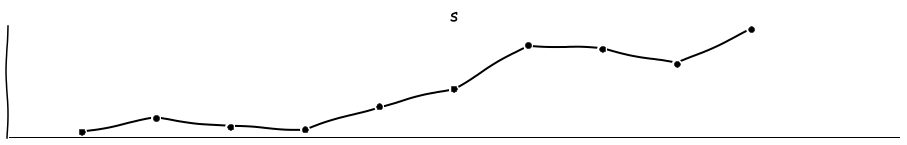

In [4]:
def randomWalk(tMax=1,sigma=1,eps=0.1):
    signal=[0]; scaleFactor = np.sqrt(eps)
    for t in np.arange(0,tMax,eps):
        signal.append(signal[-1]+np.random.normal(0,sigma*scaleFactor))
    return np.asarray(signal[1:])

signals = [randomWalk(tMax=0.1,eps=0.01)]
signal = signals[0]
signalName = 's'

plotSignal(signal,signalName)

Since our signal is just an array, we can think of it as a collection of points. The zeroth element of the array is a point at $t = 0$, the next is a point at $t = 1$, etc. The height of the point is determined by the number in the array.

Put another way, we can break a signal of length $N$ down into $N$ components. If we were to represent the component at the timepoint $i$ as a function $e_i$, it would look like:

$$
e_i(t) = 1 \text{ if } t = i \\
e_i(t) = 0 \text{ otherwise }
$$

This function is also called a "Kronecker's Delta", "the delta function", or the "unit impulse". If we were to draw it, it might look like:

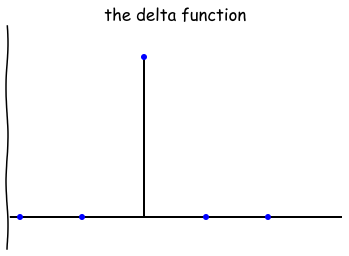

In [5]:
plotKronecker()

We construct our signal from these components as follows: we multiply each $e_i$ by the signal $s$ at the timepoint $i$. The elements that are $0$ stay zero, while the element that is $1$ now has the value $s(i)$. We then add all $N$ of the $e_i$ together, and the result is our original signal.

If you've taken linear algebra, this process may sound familiar to you -- it's exactly the way that we construct a vector out of a set of basis vectors. This is a deep connection. Just as the canonical, or usual, basis set for a two-dimensional vector space is the set $\left\{[1, \ 0], [0,\ 1]\right\}$, the canonical basis set for signals is the set of all Kronecker delta functions, each at a different point in time or space. 

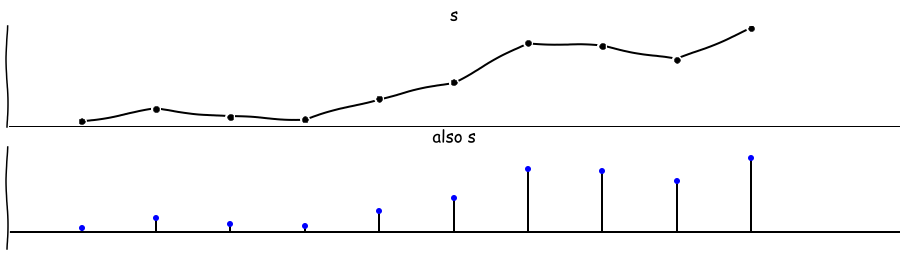

In [6]:
plotSignalAsDelta(signals[0],'s',color='b')

# Understanding Simple Transformations

For us, a simple transformation is one whose response to a signal is just the sum of its responses to all of the components in the signal and which doesn't depend on time. In mathematical terms, it is *linear* and *translation-invariant*. Since the components of our signals are just single points at different times, this means we can learn everything we want to learn about a simple transformation by seeing what it does to a single point at a single time. 

This response is called a *kernel* or an *impulse response*. If we put in two points at once, the output is just two kernels stacked on top of one another -- note that this is the same thing as multiplying by 2. If we put in one point, then wait one time step and put in a second point, we get two copies of the kernel, separated by one time step.

Let's take a look at some simple transformations. We start by defining and plotting their kernels.

In [7]:
# Define Our Kernels
pad = 15; padding = [0]*pad
delta = [1]+padding
delay = padding+delta
echo = [1]+padding+[1]+padding

kernels = [delta,delay,echo]
kernelNames = ['f',"f'","(f+f')"]
numKernels = len(kernels)

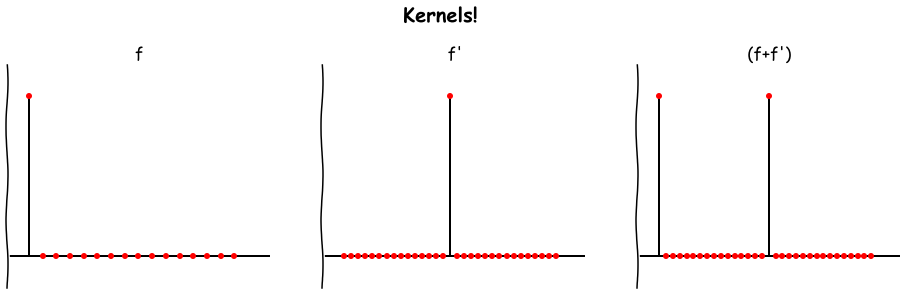

In [8]:
# Plot Our Kernels  
kernelsPlot(kernels,kernelNames)
plt.suptitle('Kernels!',fontsize=20,weight='bold',y=1.1);

Now, lets apply these kernels to our "unit impulse" -- one point. Notice what comes out: it's just the kernel!

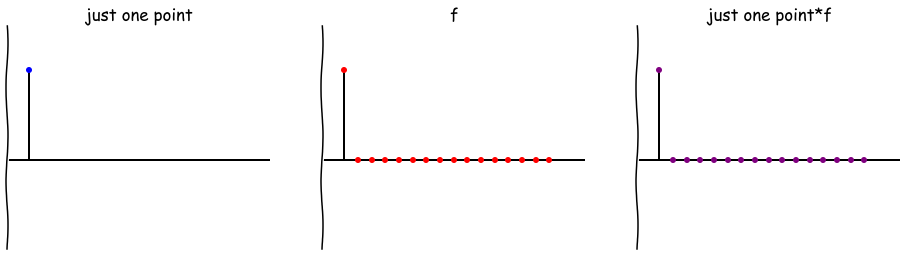

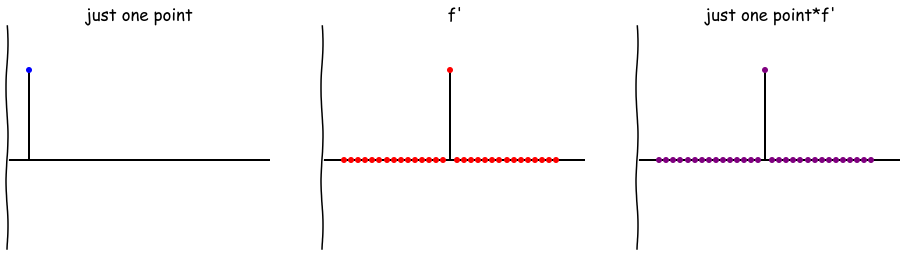

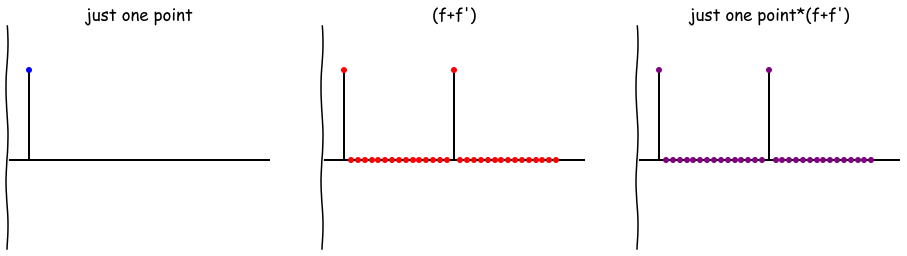

In [9]:
simpleSignal = [1]
simpleSignals = [simpleSignal]

for kernel in kernels:
    simpleSignals.append(np.convolve(simpleSignal,kernel))

convolutionPlot(simpleSignals,'just one point',kernels,kernelNames)

The "unit" in "unit impulse" means "having height 1". What happens if we scale our unit impulse so that it has a different height?

The response is just a scaled version of the kernel, just as when we put in two points at the same time.

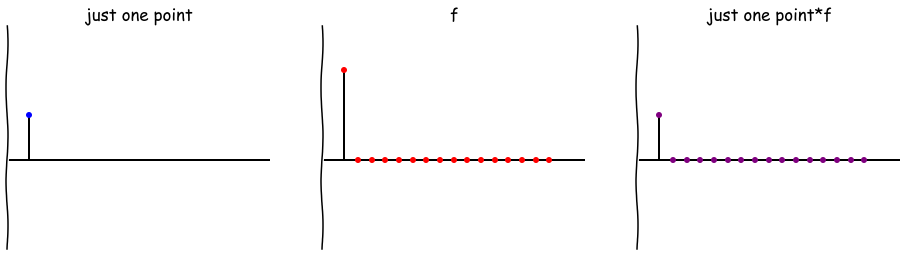

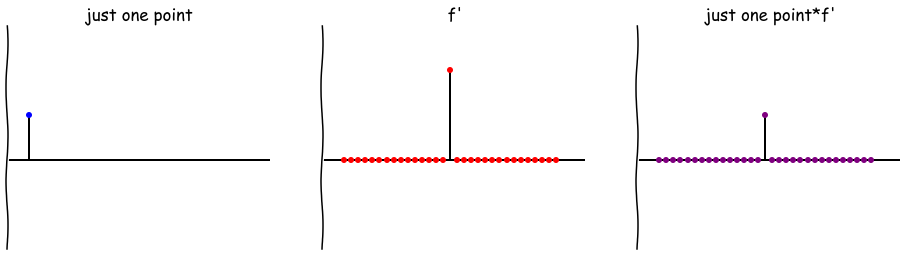

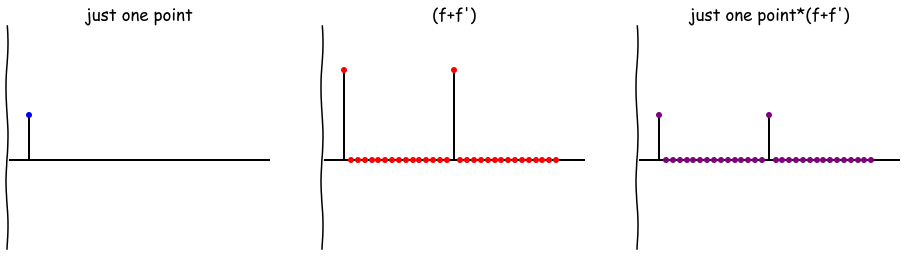

In [10]:
simpleSignal = [1/2]
simpleSignals = [simpleSignal]

for kernel in kernels:
    simpleSignals.append(np.convolve(simpleSignal,kernel))

convolutionPlot(simpleSignals,'just one point',kernels,kernelNames)

Notice that the third filter's kernel is just the sum of the first two kernels. The response of the third filter is also a sum: it's the sum of the responses to the first two kernels.

This is also true if we put two signals in: the response to a sum of inputs is just the sum of the responses to the individual inputs.

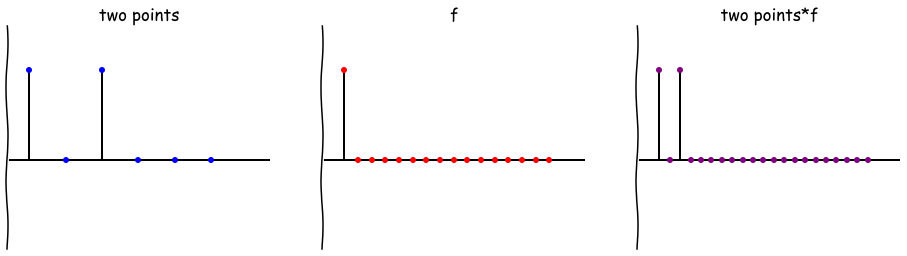

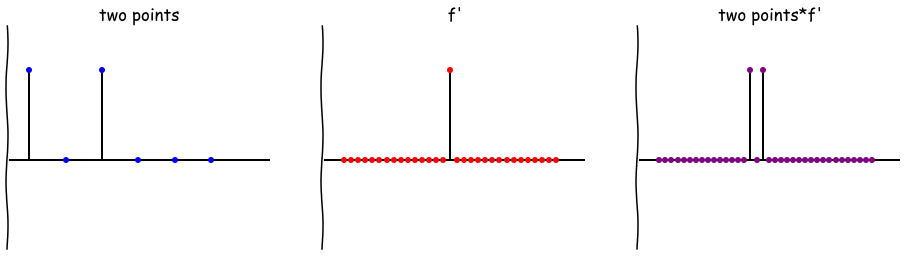

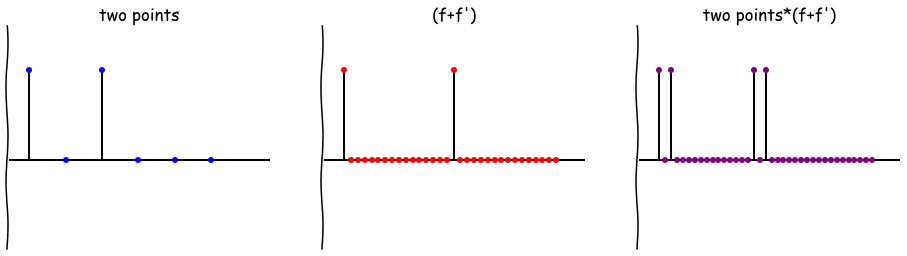

In [11]:
twoPointSignal = [1,0,1,0,0,0]
twoPointSignals = [twoPointSignal]

for kernel in kernels:
    twoPointSignals.append(np.convolve(twoPointSignal,kernel))

convolutionPlot(twoPointSignals,'two points',kernels,kernelNames)

So if we have a more complicated signal, what we need to do to get the response to that signal is combine scaled, time-shifted copies of the kernel.

Put more formally: any signal can be broken up into scaled delta functions at different times, and the response of our simple transformation to a scaled delta function at some time $t$ is just a scaled copy of the kernel starting at that time $t$.

Let's put that into mathematical terms. 

$$
\begin{align}
response_{filter}(signal) =& \sum_t response_{filter}(signal(t)) \\
    =& \sum_t response_{filter}(impulse(t))*signal(t)
\end{align}
$$

Let's simplify our notation: we'll call the signal $s$ and the response of the filter $r_f$. We'll call the response to an impulse $k$. That makes our statement above:

$$
r_{f}(s) = \sum_t k*s(t)
$$

This gives us the overall response, but what if we wanted to know the response at a particular time $t$? In order to do that, we have to keep track of all the possible contributions to the response at that time. That is, the response at $t$ will include the beginning of the response to the point at time $t$ plus the ongoing responses to the points at time $t-1$, at time $t-2$, and so on. We'll call that time difference $\Delta$. 

And what is the value of the response at $t$ to a point at $t-\Delta$? If $\Delta$ is $0$, then it's the zeroth\* element of the kernel, scaled by $s(t)$. If $\Delta$ is $1$, then it's the first element of the kernel, scaled by $s(t-1)$. If $\Delta$ is $2$, then it's the second element of the kernel, scaled by $s(t-2)$.

There's an obvious pattern here: the response at $t$ to a point at $t-\Delta$ is just the $\Delta$th element of the kernel times the value of the signal at $t-\Delta$.

We should give a name to $t-\Delta$. The traditional one is $\tau$.

To reiterate: the response to a point at time $\tau$ is going to be a $s(\tau)$-scaled copy of the kernel response. At any given time $t$ after $\tau$, there will usually be several copies stacked on top of each other, each of them at a different point in their response, depending on how long after $\tau$ the time $t$ is. This time difference is $\Delta$.

Let's write that out mathematically:

$$
r_{f}(s)(t) = \sum_{\tau+\Delta = t} s(\tau)*r(\Delta)
$$

where summing over $\tau+\Delta=t$ means summing over all pairs of $\tau$ and $\Delta$ that sum to $t$. This mathematical expression just says what we said above: the response of a filter to a signal is a group of time-shifted kernels scaled by the past values of the signal. This expression just narrows that down to a single point.

The mathematical expression above is exactly a convolution! It's not usually written that way, so for the benefit of anyone who has seen convolutions before, let's make some notation changes. First, we'll use the normal symbols: $f$ and $g$ instead of $r_f$ and $s$, and put a $*$ between them instead of putting parentheses. The result looks like

$$
g*f(t) = \sum_{\tau+\Delta = t} g(\tau)*f(\Delta)
$$

It's also standard to use $\tau$ by itself, making use of the fact that $\Delta=t-\tau$:

$$
g*f(t) = \sum_{\tau} g(\tau)*f(t-\tau)
$$

This is the more familiar expression of convolution, but I think it hides more than it shows. It's meant to evoke a dot product between the signal and a "flipped around" version of the kernel, but that ends up deeply confusing people. There's nothing "flipped around" about the kernel at all -- it's just that the later elements of the signal are contributing the earliest part of their responses. That is, as we look backwards in the signal, we find components that have made it further through their repsonse.

\* Using Python notation

# Convolution for Filtering

The kernels we used above were somewhat contrived: they mostly just repeated the signal. What if we wanted to do something more useful?

Below, we define two more useful kernels: one that takes the difference between two points, and another that takes their average.

In [12]:
# Define our filter kernels
pad = 1;  padding = [0]*pad
difference = padding+[1/2,0,-1/2]+padding;
average = padding+[1/2,1/2]+padding

kernels = [difference,average]
kernelNames = ['difference','average']
numKernels = len(kernels)

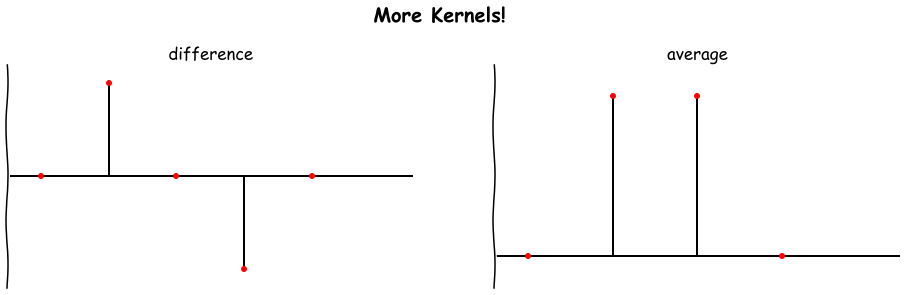

In [13]:
# Plot Our Kernels
kernelsPlot(kernels,kernelNames)    
plt.suptitle('More Kernels!',fontsize=20,weight='bold',y=1.1);

The `average` kernel has two points, both at height $1/2$. Let's plug that definition into our convolution expression:

$$
\begin{align}
r_{f}(s)(t) &= \sum_{\tau+\Delta = t} s(\tau)*r(\Delta) \\ \\
            &= s(t)*r(0) + s(t-1)*r(1) \\ \\
            &= s(t)*1/2 + s(t-1)*1/2 \\ \\
            &= \frac{s(t) + s(t-1)}{2}
\end{align}
$$

Notice that the final line is an expression for the average of two points. When we convolve this kernel with a signal, we get a *moving average*. How would we do a three-point moving average? What about an $N$-point moving average?

The `difference` kernel also has two points, but one is at height $1/2$ and the other is at height $-1/2$, and there's one at height $0$ in between. Let's plug that definition into our convolution expression:

$$
\begin{align}
r_{f}(s)(t) &= \sum_{\tau+\Delta = t} s(\tau)*r(\Delta) \\ \\
            &= s(t)*r(0) + s(t-1)*r(1) + s(t-2)*r(2) \\ \\
            &= s(t)*1/2 + s(t-2)*-1/2 \\ \\
            &= \frac{s(t) - s(t-2)}{2}
\end{align}
$$

Calculus aficionados will recognize that last line: it's the definition of a derivative! It is the change in the signal divided by the change in time -- "the rise over the run". Convolving with this kernel gives us the first derivative of our signal -- though usually, we call it a *difference* to remind ourselves that we aren't dealing with infinite numbers of points. What do you think might happen if we applied this kernel repeatedly?

Below, we use our kernels on the signal that we generated at the beginning of the section. You might be familiar with frequency-based analysis of signals. Can you see what our `difference` and `average` filters do to the signal in terms of frequnecy? Try generating new signals by rerunning the code block under **Understanding Signals**. It can be especially helpful to make longer ones by increasing the variable `tMax`.

In [14]:
# Use Our Kernels
signals = [signals[0]]
for kernel in kernels:
    signals.append(np.convolve(signals[0],kernel))

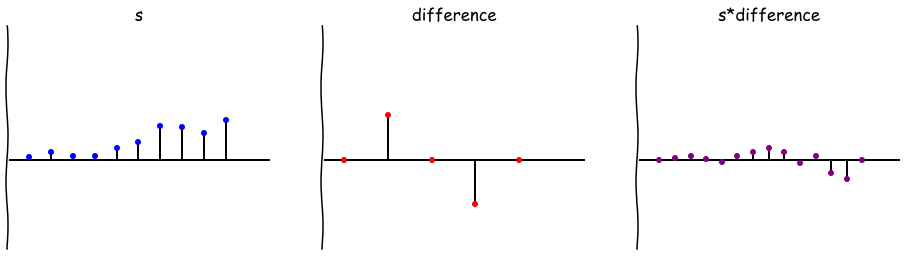

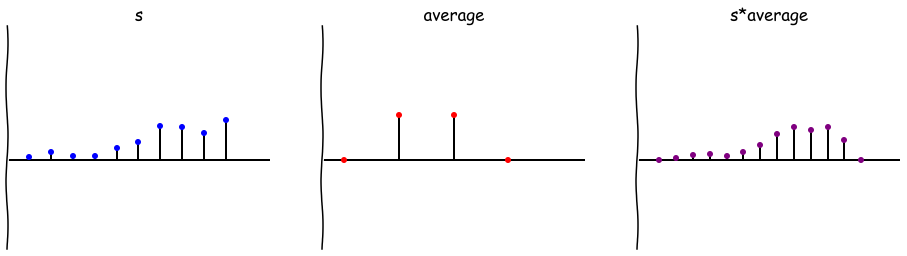

In [15]:
convolutionPlot(signals,signalName,kernels,kernelNames)

# Convolution and Probability

But convolutions are much more than a simple way of expressing what simple transformations do to signals. In fact, they arise whenever we need to keep track of multiple possible contributions to a given value.

Say we want to know the probability of getting exactly two heads in three coin tosses.
First, we need to know the probability that the coin lands heads up. That plot appears below.

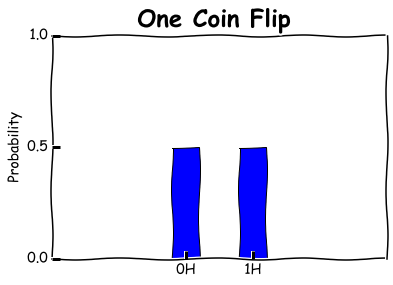

In [7]:


pmfCoin = np.asarray([1/2,1/2])

plt.figure(); locs = [0,2]; edge = 4
labels = ['0H','1H']
plt.bar(locs,pmfCoin,align='center');

probabilityPlot(plt.gca(),locs,edge,labels)
plt.suptitle("One Coin Flip",size=24,weight='bold',y=1.);

Where $1H$ refers to getting a head and $0H$ refers to getting zero heads (aka a tails).

What are the possible ways we can get two heads in three coin tosses? A table appears below.


| First toss | Second Toss | Third Toss |
|:----------:|:-----------:|:----------:|
|      H     |      H      | T          |
|      H     |      T      | H          |
|      T     |      H      | H          |


How do we compute the probability of each of those outcomes? For an individual coin flip, the probability of a head or a tail is $1/2$. The probability of any pair $HH$, $HT$, etc. is $1/2*1/2 = 1/4$. When we look at combined events, all we have to do is multiply the probabilities.

And what is the overall probability that we get two heads? We just need to add up all the probabilities of the individual ways to get two heads. 

To write that out mathematically, we split our result into two parts: the first two tosses, and the third toss. We'll call those components $A$ and $B$, and call our result $C$. In order to figure out the overall probability of our result $C$, we need to add up all the probabilities of combinations $A$ and $B$ that give us $C$. In our case, those combinations would be:

|  A | B |
|:--:|:-:|
| HH | T |
| HT | H |
| TH | H |

We can find the probability of any given combination by multiplying together the probabilities of its components $A$ and $B$, but to find the probability of our outcome $C$, we need to take all combinations into account:

$$
p(C) = \sum_{A+B=C} p(A)*p(B)
$$

Now doesn't that formula look familiar! It's a convolution, where the two functions being convolved are the probability functions of $A$ and $B$!

Note that this applies for any number of repetitions. If we want to know how likely it is to get any particular number $k$ of heads in some number of coin tosses $n$, we just need to look at the $n$th convolution of the coin flip probability distribution with itself.

The code block below generates an animated version of this process, showing you the result of each convolution in turn. Feel free to change the `pmfCoin` above (I suggest `[1/6]*6`, which gives the probability distribution for a six-sided coin, also known as a "die") or change the number of `iters` below.

In [9]:
pmfs = [pmfCoin]; #kernel = [1/2,1/2]
iters = 25; #change me to get different numbers of flips
mx = iters
locs = list(range(mx+2))
extendedPMF = np.hstack([pmfs[0],[0]*(mx+2-len(pmfs[0]))])
edge = 2
fig = plt.figure(figsize=(12,8)); pmfAx = plt.subplot(111);
pmfBars = pmfAx.bar(locs,extendedPMF,align='center')
labels = [str(n)+"H" for n in range(mx+1)]

probabilityPlot(plt.gca(),locs,edge,labels)
plt.suptitle("A Series of "+str(iters)+" Coin Flips",size=24,weight='bold',y=1.)

def init():
    return

def animate(_,pmfs):
    [pmfBars[idx].set_height(h)
         for idx,h in enumerate(pmfs[-1])]
    pmfs.append(np.convolve(pmfs[-1],pmfs[0])) #Convolution!
    return

anim = animation.FuncAnimation(fig, animate, init_func=init,
                                    fargs=[pmfs], frames=iters, 
                                    interval=2)

display_animation(anim,fps=10) #change the FramesPerSecond here, for longer or shorter videos